In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import glob
import datetime
from pyproj import Proj, Transformer
import os
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
def to_binary_string(num):
    if np.isnan(num):
        return np.nan
    else:
        return f'{int(num):b}'

In [3]:
"""
Export coordinates for each urban area
KEY: [utm zone, T/F Northern Hemisphere]
"""
proj_zone = {
    'DMV':[18, True], 'NYC':[18, True], 'Phoenix':[12, True], 'Miami':[17, True], 'Chicago':[16, True], 'Denver':[13, True],
    'Seattle':[10, True], 'San_Francisco':[10, True], 'Los_Angeles':[11, True], 'Atlanta':[16, True], 'Toronto':[17, True],
    'Mexico_City':[14, True], 'Las_Vegas':[11, True], 'Salt_Lake_City':[12, True], 'Dallas':[14, True], 'Houston':[15, True],
    'New_Orleans':[15, True], 'St_Louis':[15, True], 'Minneapolis':[15, True], 'Jacksonville':[17, True], 'Charlotte':[17, True],
    'Philadelphia':[18, True], 'San_Diego':[11, True], 'San_Juan':[19, True], 'Montreal':[18, True], 'Guadalajara':[13, True],
    'Monterrey':[14, True], 'Cancun':[16, True], 'Billings':[12, True], 'Guatemala_City':[15, True], 'San_Jose':[16, True],
    'Havana':[17, True], 'Santo_Domingo':[19, True], 'Tegucigalpa':[16, True], 'Managua':[16, True], 'Panama_City':[17, True],
    'Bogota':[18, True], 'Lima':[18, False], 'Quito':[17, True], 'Santiago':[19, False], 'Buenos_Aires':[21, False],
    'Sao_Paulo':[23, False], 'Manaus':[20, False], 'Punta_Arenas':[19, False],
    'La_Paz':[19, False], 'Montevideo':[21, False], 'Brasilia':[22, False], 'Caracas':[19, True]
}

In [4]:
cities = sorted(list(proj_zone.keys()))

In [5]:
city = 'Atlanta'
city_zone = proj_zone[city]
city_zone

[16, True]

In [6]:
# Define UTM18N projection (WGS84 datum)
if city_zone[1]:
    crs_prefix = '326'
else:
    crs_prefix = '327'
proj_code = f'EPSG:{crs_prefix}{city_zone[0]}'
utm_proj = Proj(projparams=proj_code)

## Produce latlons

In [32]:
def stacked_to_latlon(pt):
    return utm_proj(pt[0], pt[1], inverse=True)

In [48]:
def create_city_latlons(city):
    city_dir = f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/{city}'
    Landsat_file_list = glob.glob(f'{city_dir}/processed_Landsat/*')
    GOES_file_list = glob.glob(f'{city_dir}/GOES_2022_1/*')
    
    # Produce Landsat latlons
    ds = xr.open_dataset(Landsat_file_list[0])
    y, x = np.meshgrid(ds['y'], ds['x'])
    utm_coords = np.stack((x,y)).T.reshape(-1,2)
    
    latlon_pts = np.array(list(map(stacked_to_latlon, utm_coords)))
    latlon_pts = latlon_pts.reshape((3000,3000,2))
    xr.DataArray(latlon_pts, dims=['longitude','latitude','latlon_pts']).to_netcdf(f'{city_dir}/{city}_Landsat_latlons.nc')
    
    # Produce GOES latlons
    ds = xr.open_dataset(GOES_file_list[0])
    ds = ds.reindex(y=ds.y[::-1])
    y, x = np.meshgrid(ds['y'], ds['x'])
    utm_coords = np.stack((x,y)).T.reshape(-1,2)
    
    latlon_pts = np.array(list(map(stacked_to_latlon, utm_coords)))
    latlon_pts = latlon_pts.reshape((45,45,2))
    xr.DataArray(latlon_pts, dims=['longitude','latitude','latlon_pts']).to_netcdf(f'{city_dir}/{city}_GOES_latlons.nc')

In [51]:
for city in cities:
    city_zone = proj_zone[city]
    if city_zone[1]:
        crs_prefix = '326'
    else:
        crs_prefix = '327'
    proj_code = f'EPSG:{crs_prefix}{city_zone[0]}'
    utm_proj = Proj(projparams=proj_code)
    create_city_latlons(city)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

# Sample Code

## Landsat

In [16]:
#times_Landsat = pd.read_csv(f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Landsat_times/Landsat_times_{city}.csv').value
times_Landsat = pd.read_csv(f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Landsat_times/Landsat9_times_{city}.csv').value
times_Landsat

0     1.642176e+12
1     1.643558e+12
2     1.644941e+12
3     1.646323e+12
4     1.647706e+12
5     1.649088e+12
6     1.650470e+12
7     1.651853e+12
8     1.653235e+12
9     1.654618e+12
10    1.656000e+12
11    1.657382e+12
12    1.658765e+12
13    1.660147e+12
14    1.661530e+12
15    1.662912e+12
16    1.664294e+12
17    1.665677e+12
18    1.668442e+12
19    1.671206e+12
20    1.676736e+12
21    1.678118e+12
22    1.682266e+12
23    1.683648e+12
24    1.685030e+12
25    1.686413e+12
26    1.687795e+12
27    1.689178e+12
28    1.690560e+12
29    1.691942e+12
30    1.694707e+12
31    1.696090e+12
32    1.697472e+12
33    1.698854e+12
34    1.700237e+12
35    1.703002e+12
Name: value, dtype: float64

In [17]:
Landsat_root = f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/{city}/Landsat'
Landsat_tif_list = glob.glob(Landsat_root+'/*.tif')
Landsat_tif_list

['/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202203191600.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202311011600.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202205061559.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202304231559.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202211141600.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202310161600.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202306261559.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_20221013160

In [18]:
def sort_func_Landsat(s, form=int):
    if form == int:
        return int(s.split(f'{city}_')[1].split('.tif')[0])
    else:
        return str(s.split(f'{city}_')[1].split('.tif')[0])

In [19]:
Landsat_tif_list = sorted(Landsat_tif_list, key=sort_func_Landsat)
Landsat_tif_list

['/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202201141600.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202201301600.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202202151600.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202203031600.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202203191600.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202204041559.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_202204201559.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Charlotte/Landsat/Landsat9_Sentinel_image_Charlotte_20220506155

In [15]:
dsLS = rxr.open_rasterio(Landsat_tif_list[0])[:,:3000,:3000]
dsLS = dsLS.reindex(y=dsLS.y[::-1]) # Invert y-axis so that values are increasing instead of decreasing with index
geotiff_dsLS = dsLS.to_dataset('band')

In [16]:
geotiff_dsLS

<xarray.Dataset> Size: 936MB
Dimensions:      (y: 3000, x: 3000)
Coordinates:
  * x            (x) float64 24kB 2.92e+05 2.92e+05 ... 3.819e+05 3.82e+05
  * y            (y) float64 24kB 4.282e+06 4.282e+06 ... 4.372e+06 4.372e+06
    spatial_ref  int64 8B 0
Data variables: (12/13)
    1            (y, x) float64 72MB ...
    2            (y, x) float64 72MB ...
    3            (y, x) float64 72MB ...
    4            (y, x) float64 72MB ...
    5            (y, x) float64 72MB ...
    6            (y, x) float64 72MB ...
    ...           ...
    8            (y, x) float64 72MB ...
    9            (y, x) float64 72MB ...
    10           (y, x) float64 72MB ...
    11           (y, x) float64 72MB ...
    12           (y, x) float64 72MB ...
    13           (y, x) float64 72MB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'S...

In [17]:
y, x = np.meshgrid(geotiff_dsLS['y'], geotiff_dsLS['x'])
utm_coords = np.stack((x,y)).T.reshape(-1,2)
utm_coords

array([[ 292005., 4282245.],
       [ 292035., 4282245.],
       [ 292065., 4282245.],
       ...,
       [ 381915., 4372215.],
       [ 381945., 4372215.],
       [ 381975., 4372215.]], shape=(9000000, 2))

In [18]:
latlon_pts = np.array(list(map(stacked_to_latlon, utm_coords)))
latlon_pts = latlon_pts.reshape((3000,3000,2))
latlon_pts

array([[[-77.39061145,  38.66437668],
        [-77.39026692,  38.66438372],
        [-77.38992239,  38.66439077],
        ...,
        [-76.35759371,  38.68093502],
        [-76.3572489 ,  38.68093902],
        [-76.35690408,  38.68094302]],

       [[-77.39062043,  38.6646468 ],
        [-77.3902759 ,  38.66465384],
        [-77.38993137,  38.66466089],
        ...,
        [-76.35759882,  38.6812053 ],
        [-76.357254  ,  38.6812093 ],
        [-76.35690919,  38.6812133 ]],

       [[-77.39062942,  38.66491692],
        [-77.39028489,  38.66492396],
        [-77.38994036,  38.66493101],
        ...,
        [-76.35760392,  38.68147557],
        [-76.35725911,  38.68147958],
        [-76.35691429,  38.68148358]],

       ...,

       [[-77.41809221,  39.47386319],
        [-77.41774373,  39.47387044],
        [-77.41739525,  39.47387769],
        ...,
        [-76.37321213,  39.49090355],
        [-76.37286335,  39.49090767],
        [-76.37251458,  39.49091179]],

       [[-77.41

In [19]:
latlons_dir = '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset'

In [20]:
xr.DataArray(latlon_pts, dims=['longitude','latitude','latlon_pts']).to_netcdf(f'{latlons_dir}/{city}/{city}_Landsat_latlons.nc')
xr.open_dataarray(f'{latlons_dir}/{city}/{city}_Landsat_latlons.nc').values

array([[[-77.39061145,  38.66437668],
        [-77.39026692,  38.66438372],
        [-77.38992239,  38.66439077],
        ...,
        [-76.35759371,  38.68093502],
        [-76.3572489 ,  38.68093902],
        [-76.35690408,  38.68094302]],

       [[-77.39062043,  38.6646468 ],
        [-77.3902759 ,  38.66465384],
        [-77.38993137,  38.66466089],
        ...,
        [-76.35759882,  38.6812053 ],
        [-76.357254  ,  38.6812093 ],
        [-76.35690919,  38.6812133 ]],

       [[-77.39062942,  38.66491692],
        [-77.39028489,  38.66492396],
        [-77.38994036,  38.66493101],
        ...,
        [-76.35760392,  38.68147557],
        [-76.35725911,  38.68147958],
        [-76.35691429,  38.68148358]],

       ...,

       [[-77.41809221,  39.47386319],
        [-77.41774373,  39.47387044],
        [-77.41739525,  39.47387769],
        ...,
        [-76.37321213,  39.49090355],
        [-76.37286335,  39.49090767],
        [-76.37251458,  39.49091179]],

       [[-77.41

In [21]:
# For Landsat/Sentinel tifs
geotiff_dsLS = geotiff_dsLS.rename({1:'Landsat_blue_sfc_reflectance', 2:'Landsat_green_sfc_reflectance',
                                    3:'Landsat_red_sfc_reflectance', 4:'Landsat_NIR_sfc_reflectance',
                                    5:'Landsat_SWIR1_sfc_reflectance', 6:'Landsat_SWIR2_sfc_reflectance',
                                    7:'Landsat_LST', 8:'Landsat_cloud_mask', 9:'Sentinel1_VV', 10:'Sentinel1_VH', 11:'Sentinel1_HH',
                                    12:'Sentinel1_HV', 13:'Sentinel1_incidence_angle'})

In [22]:
geotiff_dsLS['Landsat_cloud_mask'].values

array([[55052., 55052., 55052., ..., 55052., 55052., 55052.],
       [55052., 55052., 55052., ..., 55052., 55052., 55052.],
       [55052., 55052., 55052., ..., 55052., 55052., 55052.],
       ...,
       [55052., 55052., 55052., ..., 55052., 55052., 55052.],
       [55052., 55052., 55052., ..., 55052., 55052., 55052.],
       [55052., 55052., 55052., ..., 55052., 55052., 55052.]],
      shape=(3000, 3000))

In [23]:
binary_vectorized = np.vectorize(to_binary_string)
mask = binary_vectorized(geotiff_dsLS.Landsat_cloud_mask.values)

In [24]:
mask

array([['1101011100001100', '1101011100001100', '1101011100001100', ...,
        '1101011100001100', '1101011100001100', '1101011100001100'],
       ['1101011100001100', '1101011100001100', '1101011100001100', ...,
        '1101011100001100', '1101011100001100', '1101011100001100'],
       ['1101011100001100', '1101011100001100', '1101011100001100', ...,
        '1101011100001100', '1101011100001100', '1101011100001100'],
       ...,
       ['1101011100001100', '1101011100001100', '1101011100001100', ...,
        '1101011100001100', '1101011100001100', '1101011100001100'],
       ['1101011100001100', '1101011100001100', '1101011100001100', ...,
        '1101011100001100', '1101011100001100', '1101011100001100'],
       ['1101011100001100', '1101011100001100', '1101011100001100', ...,
        '1101011100001100', '1101011100001100', '1101011100001100']],
      shape=(3000, 3000), dtype='<U16')

In [25]:
geotiff_dsLS['Landsat_cloud_mask'].values = mask

In [26]:
geotiff_dsLS['Landsat_cloud_mask'].attrs['bitmask_key'] = \
"Bit 0: Fill\n\
Bit 1: Dilated Cloud\n\
Bit 2: Cirrus (high confidence)\n\
Bit 3: Cloud\n\
Bit 4: Cloud Shadow\n\
Bit 5: Snow\n\
Bit 6: Clear\n\t0: Cloud or Dilated Cloud bits are set\n\t1: Cloud and Dilated Cloud bits are not set\n\
Bit 7: Water\n\
Bits 8-9: Cloud Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
Bits 10-11: Cloud Shadow Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
Bits 12-13: Snow/Ice Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
Bits 14-15: Cirrus Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High"

In [27]:
geotiff_dsLS

<xarray.Dataset> Size: 1GB
Dimensions:                        (y: 3000, x: 3000)
Coordinates:
  * x                              (x) float64 24kB 2.92e+05 ... 3.82e+05
  * y                              (y) float64 24kB 4.282e+06 ... 4.372e+06
    spatial_ref                    int64 8B 0
Data variables: (12/13)
    Landsat_blue_sfc_reflectance   (y, x) float64 72MB ...
    Landsat_green_sfc_reflectance  (y, x) float64 72MB ...
    Landsat_red_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_NIR_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_SWIR1_sfc_reflectance  (y, x) float64 72MB ...
    Landsat_SWIR2_sfc_reflectance  (y, x) float64 72MB ...
    ...                             ...
    Landsat_cloud_mask             (y, x) <U16 576MB '1101011100001100' ... '...
    Sentinel1_VV                   (y, x) float64 72MB ...
    Sentinel1_VH                   (y, x) float64 72MB ...
    Sentinel1_HH                   (y, x) float64 72MB ...
    Sentinel1_HV                   (y, x) float64 72MB ...
    Sentinel1_incidence_angle      (y, x) float64 72MB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'S...

In [28]:
dt = datetime.datetime.fromtimestamp(times_Landsat[0]/1000, datetime.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
geotiff_dsLS = geotiff_dsLS.assign_coords({'datetime':dt})

In [29]:
del geotiff_dsLS.attrs['long_name']

In [30]:
geotiff_dsLS

<xarray.Dataset> Size: 1GB
Dimensions:                        (y: 3000, x: 3000)
Coordinates:
  * x                              (x) float64 24kB 2.92e+05 ... 3.82e+05
  * y                              (y) float64 24kB 4.282e+06 ... 4.372e+06
    spatial_ref                    int64 8B 0
    datetime                       <U20 80B '2022-01-16T15:46:41Z'
Data variables: (12/13)
    Landsat_blue_sfc_reflectance   (y, x) float64 72MB ...
    Landsat_green_sfc_reflectance  (y, x) float64 72MB ...
    Landsat_red_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_NIR_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_SWIR1_sfc_reflectance  (y, x) float64 72MB ...
    Landsat_SWIR2_sfc_reflectance  (y, x) float64 72MB ...
    ...                             ...
    Landsat_cloud_mask             (y, x) <U16 576MB '1101011100001100' ... '...
    Sentinel1_VV                   (y, x) float64 72MB ...
    Sentinel1_VH                   (y, x) float64 72MB ...
    Sentinel1_HH                   (y, x) float64 72MB ...
    Sentinel1_HV                   (y, x) float64 72MB ...
    Sentinel1_incidence_angle      (y, x) float64 72MB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [31]:
for variable in ['Sentinel1_VV', 'Sentinel1_VH', 'Sentinel1_HH', 'Sentinel1_HV']:
    geotiff_dsLS[variable].values = np.where(geotiff_dsLS[variable].values > 1, np.nan, geotiff_dsLS[variable].values)
geotiff_dsLS['Sentinel1_incidence_angle'].values = np.where(geotiff_dsLS['Sentinel1_incidence_angle'].values < 0, np.nan,
                                                  geotiff_dsLS['Sentinel1_incidence_angle'].values)

In [32]:
geotiff_dsLS

<xarray.Dataset> Size: 1GB
Dimensions:                        (y: 3000, x: 3000)
Coordinates:
  * x                              (x) float64 24kB 2.92e+05 ... 3.82e+05
  * y                              (y) float64 24kB 4.282e+06 ... 4.372e+06
    spatial_ref                    int64 8B 0
    datetime                       <U20 80B '2022-01-16T15:46:41Z'
Data variables: (12/13)
    Landsat_blue_sfc_reflectance   (y, x) float64 72MB ...
    Landsat_green_sfc_reflectance  (y, x) float64 72MB ...
    Landsat_red_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_NIR_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_SWIR1_sfc_reflectance  (y, x) float64 72MB ...
    Landsat_SWIR2_sfc_reflectance  (y, x) float64 72MB ...
    ...                             ...
    Landsat_cloud_mask             (y, x) <U16 576MB '1101011100001100' ... '...
    Sentinel1_VV                   (y, x) float64 72MB -7.214 -6.531 ... -12.85
    Sentinel1_VH                   (y, x) float64 72MB -12.13 -10.62 ... -23.28
    Sentinel1_HH                   (y, x) float64 72MB nan nan nan ... nan nan
    Sentinel1_HV                   (y, x) float64 72MB nan nan nan ... nan nan
    Sentinel1_incidence_angle      (y, x) float64 72MB 38.27 38.27 ... 33.7 33.7
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [29]:
geotiff_dsLS['Landsat_blue_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
geotiff_dsLS['Landsat_blue_sfc_reflectance'].attrs['units'] = '1'
geotiff_dsLS['Landsat_blue_sfc_reflectance'].attrs['valid_min'] = 0
geotiff_dsLS['Landsat_blue_sfc_reflectance'].attrs['valid_max'] = 1
geotiff_dsLS['Landsat_blue_sfc_reflectance'].attrs['missing_value'] = np.nan
geotiff_dsLS['Landsat_blue_sfc_reflectance'].attrs['wavelength'] = '0.452-0.512 μm'

geotiff_dsLS['Landsat_green_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
geotiff_dsLS['Landsat_green_sfc_reflectance'].attrs['units'] = '1'
geotiff_dsLS['Landsat_green_sfc_reflectance'].attrs['valid_min'] = 0
geotiff_dsLS['Landsat_green_sfc_reflectance'].attrs['valid_max'] = 1
geotiff_dsLS['Landsat_green_sfc_reflectance'].attrs['missing_value'] = np.nan
geotiff_dsLS['Landsat_green_sfc_reflectance'].attrs['wavelength'] = '0.533-0.590 μm'

geotiff_dsLS['Landsat_red_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
geotiff_dsLS['Landsat_red_sfc_reflectance'].attrs['units'] = '1'
geotiff_dsLS['Landsat_red_sfc_reflectance'].attrs['valid_min'] = 0
geotiff_dsLS['Landsat_red_sfc_reflectance'].attrs['valid_max'] = 1
geotiff_dsLS['Landsat_red_sfc_reflectance'].attrs['missing_value'] = np.nan
geotiff_dsLS['Landsat_red_sfc_reflectance'].attrs['wavelength'] = '0.636-0.673 μm'

geotiff_dsLS['Landsat_NIR_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
geotiff_dsLS['Landsat_NIR_sfc_reflectance'].attrs['units'] = '1'
geotiff_dsLS['Landsat_NIR_sfc_reflectance'].attrs['valid_min'] = 0
geotiff_dsLS['Landsat_NIR_sfc_reflectance'].attrs['valid_max'] = 1
geotiff_dsLS['Landsat_NIR_sfc_reflectance'].attrs['missing_value'] = np.nan
geotiff_dsLS['Landsat_NIR_sfc_reflectance'].attrs['wavelength'] = '0.851-0.879 μm'

geotiff_dsLS['Landsat_SWIR1_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
geotiff_dsLS['Landsat_SWIR1_sfc_reflectance'].attrs['units'] = '1'
geotiff_dsLS['Landsat_SWIR1_sfc_reflectance'].attrs['valid_min'] = 0
geotiff_dsLS['Landsat_SWIR1_sfc_reflectance'].attrs['valid_max'] = 1
geotiff_dsLS['Landsat_SWIR1_sfc_reflectance'].attrs['missing_value'] = np.nan
geotiff_dsLS['Landsat_SWIR1_sfc_reflectance'].attrs['wavelength'] = '1.566-1.651 μm'

geotiff_dsLS['Landsat_SWIR2_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
geotiff_dsLS['Landsat_SWIR2_sfc_reflectance'].attrs['units'] = '1'
geotiff_dsLS['Landsat_SWIR2_sfc_reflectance'].attrs['valid_min'] = 0
geotiff_dsLS['Landsat_SWIR2_sfc_reflectance'].attrs['valid_max'] = 1
geotiff_dsLS['Landsat_SWIR2_sfc_reflectance'].attrs['missing_value'] = np.nan
geotiff_dsLS['Landsat_SWIR2_sfc_reflectance'].attrs['wavelength'] = '2.107-2.294 μm'

geotiff_dsLS['Landsat_LST'].attrs['standard_name'] = 'surface_temperature'
geotiff_dsLS['Landsat_LST'].attrs['units'] = 'K'
geotiff_dsLS['Landsat_LST'].attrs['valid_min'] = 0
geotiff_dsLS['Landsat_LST'].attrs['valid_max'] = 373
geotiff_dsLS['Landsat_LST'].attrs['missing_value'] = np.nan
geotiff_dsLS['Landsat_LST'].attrs['wavelength'] = '10.60-11.19 μm'

geotiff_dsLS['Landsat_cloud_mask'].attrs['standard_name'] = 'quality_flag'
geotiff_dsLS['Landsat_cloud_mask'].attrs['long_name'] = 'pixel quality mask'
geotiff_dsLS['Landsat_cloud_mask'].attrs['missing_value'] = np.nan

geotiff_dsLS['Sentinel1_VV'].attrs['standard_name'] = 'surface_backwards_scattering_coefficient_of_radar_wave'
geotiff_dsLS['Sentinel1_VV'].attrs['units'] = 'dB'
geotiff_dsLS['Sentinel1_VV'].attrs['valid_max'] = 1
geotiff_dsLS['Sentinel1_VV'].attrs['missing_value'] = np.nan
geotiff_dsLS['Sentinel1_VV'].attrs['wavelength'] = '5.55 cm'

geotiff_dsLS['Sentinel1_VH'].attrs['standard_name'] = 'surface_backwards_scattering_coefficient_of_radar_wave'
geotiff_dsLS['Sentinel1_VH'].attrs['units'] = 'dB'
geotiff_dsLS['Sentinel1_VH'].attrs['valid_max'] = 1
geotiff_dsLS['Sentinel1_VH'].attrs['missing_value'] = np.nan
geotiff_dsLS['Sentinel1_VH'].attrs['wavelength'] = '5.55 cm'

geotiff_dsLS['Sentinel1_HH'].attrs['standard_name'] = 'surface_backwards_scattering_coefficient_of_radar_wave'
geotiff_dsLS['Sentinel1_HH'].attrs['units'] = 'dB'
geotiff_dsLS['Sentinel1_HH'].attrs['valid_max'] = 1
geotiff_dsLS['Sentinel1_HH'].attrs['missing_value'] = np.nan
geotiff_dsLS['Sentinel1_HH'].attrs['wavelength'] = '5.55 cm'

geotiff_dsLS['Sentinel1_HV'].attrs['standard_name'] = 'surface_backwards_scattering_coefficient_of_radar_wave'
geotiff_dsLS['Sentinel1_HV'].attrs['units'] = 'dB'
geotiff_dsLS['Sentinel1_HV'].attrs['valid_max'] = 1
geotiff_dsLS['Sentinel1_HV'].attrs['missing_value'] = np.nan
geotiff_dsLS['Sentinel1_HV'].attrs['wavelength'] = '5.55 cm'

geotiff_dsLS['Sentinel1_incidence_angle'].attrs['standard_name'] = 'angle_of_incidence'
geotiff_dsLS['Sentinel1_incidence_angle'].attrs['units'] = 'degree'
geotiff_dsLS['Sentinel1_incidence_angle'].attrs['valid_min'] = 0
geotiff_dsLS['Sentinel1_incidence_angle'].attrs['valid_max'] = 90
geotiff_dsLS['Sentinel1_incidence_angle'].attrs['missing_value'] = np.nan

In [30]:
city_str_dict = {
    'Atlanta': 'Atlanta, Georgia, USA',
    'Billings': 'Billings, Montana, USA',
    'Bogota': 'Bogota, Colombia',
    'Brasilia': 'Brasilia, Brazil',
    'Buenos_Aires': 'Buenos Aires, Argentina',
    'Cancun': 'Cancun, Mexico',
    'Caracas': 'Caracas, Venezuela',
    'Charlotte': 'Charlotte, North Carolina, USA',
    'Chicago': 'Chicago, Illinois, USA',
    'Dallas': 'Dallas, Texas, USA and Fort Worth, Texas, USA',
    'Denver': 'Denver, Colorado, USA',
    'Guadalajara': 'Guadalajara, Mexico',
    'Guatemala_City': 'Guatemala City, Guatemala',
    'Havana': 'Havana, Cuba',
    'Houston': 'Houston, Texas, USA',
    'Jacksonville': 'Jacksonville, Florida, USA',
    'La_Paz': 'La Paz, Bolivia',
    'Las_Vegas': 'Las Vegas, Nevada, USA',
    'Lima': 'Lima, Peru',
    'Los_Angeles': 'Los Angeles, California, USA',
    'Managua': 'Managua, Nicaragua',
    'Manaus': 'Manaus, Brazil',
    'Mexico_City': 'Mexico City, Mexico',
    'Miami': 'Miami, Florida, USA',
    'Minneapolis': 'Minneapolis, Minnesota, USA',
    'Monterrey': 'Monterrey, Mexico',
    'Montevideo': 'Montevideo, Uruguay',
    'Montreal': 'Montreal, Quebec, Canada',
    'New_Orleans': 'New Orleans, Louisiana, USA',
    'NYC': 'New York City, New York, USA',
    'Panama_City': 'Panama City, Panama',
    'Philadelphia': 'Philadelphia, Pennsylvania, USA',
    'Phoenix': 'Phoenix, Arizona, USA',
    'Punta_Arenas': 'Punta Arenas, Chile',
    'Quito': 'Quito, Ecuador',
    'Salt_Lake_City': 'Salt Lake City, Utah, USA',
    'San_Diego': 'San Diego, California, USA and Tijuana, Mexico',
    'San_Francisco': 'San Francisco, California, USA and San Jose, California, USA',
    'San_Jose': 'San Jose, Costa Rica',
    'San_Juan': 'San Juan, Puerto Rico',
    'Santiago': 'Santiago, Chile',
    'Santo_Domingo': 'Santo Domingo, Dominican Republic',
    'Sao_Paulo': 'Sao Paulo, Brazil',
    'Seattle': 'Seattle, Washington, USA',
    'St_Louis': 'St Louis, Missouri, USA',
    'Tegucigalpa': 'Tegucigalpa, Honduras',
    'Toronto': 'Toronto, Ontario, USA',
    'DMV': 'Washington, DC, USA and Baltimore, Maryland, USA'
}

In [31]:
geotiff_dsLS.attrs['title'] = f'Landsat 8/9 and Sentinel-1 data for {city_str_dict[city]}'
geotiff_dsLS.attrs['institution'] = 'University of Maryland, College Park'
geotiff_dsLS.attrs['source'] = 'Satellite observation'

In [36]:
geotiff_dsLS['y'].attrs['standard_name'] = 'projection_y_coordinate'
geotiff_dsLS['y'].attrs['long_name'] = 'UTM Northing'
geotiff_dsLS['y'].attrs['units'] = 'm'

geotiff_dsLS['x'].attrs['standard_name'] = 'projection_x_coordinate'
geotiff_dsLS['x'].attrs['long_name'] = 'UTM Easting'
geotiff_dsLS['x'].attrs['units'] = 'm'

geotiff_dsLS['datetime'].attrs['long_name'] = 'datetime'
geotiff_dsLS['datetime'].attrs['units'] = 'YYYY-mm-DDTHH:MM:SSZ'
geotiff_dsLS['datetime'].attrs['calendar'] = 'utc'

In [37]:
geotiff_dsLS

<xarray.Dataset> Size: 1GB
Dimensions:                        (y: 3000, x: 3000)
Coordinates:
  * x                              (x) float64 24kB 2.92e+05 ... 3.82e+05
  * y                              (y) float64 24kB 4.282e+06 ... 4.372e+06
    spatial_ref                    int64 8B 0
    datetime                       <U20 80B '2022-01-16T15:46:41Z'
Data variables: (12/13)
    Landsat_blue_sfc_reflectance   (y, x) float64 72MB ...
    Landsat_green_sfc_reflectance  (y, x) float64 72MB ...
    Landsat_red_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_NIR_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_SWIR1_sfc_reflectance  (y, x) float64 72MB ...
    Landsat_SWIR2_sfc_reflectance  (y, x) float64 72MB ...
    ...                             ...
    Landsat_cloud_mask             (y, x) <U16 576MB '1101011100001100' ... '...
    Sentinel1_VV                   (y, x) float64 72MB -7.214 -6.531 ... -12.85
    Sentinel1_VH                   (y, x) float64 72MB -12.13 -10.62 ... -23.28
    Sentinel1_HH                   (y, x) float64 72MB nan nan nan ... nan nan
    Sentinel1_HV                   (y, x) float64 72MB nan nan nan ... nan nan
    Sentinel1_incidence_angle      (y, x) float64 72MB 38.27 38.27 ... 33.7 33.7
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    title:          Landsat 8/9 and Sentinel-1 data for Washington, DC, USA a...
    institution:    University of Maryland, College Park
    source:         Satellite observation

In [38]:
#geotiff_dsLS.to_netcdf('../../heat_data/Landsat_Sentinel_DMV_processed/processed_Landsat_0.nc')
#geotiff_dsLS.to_netcdf('/home/jonstar/scratch.gcurbanheat/processed_Landsat_0.nc')
geotiff_dsLS.to_netcdf('/glade/derecho/scratch/jstarfeldt/processed_Landsat_0.nc')

In [21]:
xr.open_dataset('/glade/derecho/scratch/jstarfeldt/processed_Landsat_0.nc')

<xarray.Dataset> Size: 936MB
Dimensions:                        (y: 3000, x: 3000)
Coordinates:
  * x                              (x) float64 24kB 2.92e+05 ... 3.82e+05
  * y                              (y) float64 24kB 4.282e+06 ... 4.372e+06
    datetime                       object 8B ...
Data variables: (12/14)
    Landsat_cloud_mask             (y, x) object 72MB ...
    Landsat_blue_sfc_reflectance   (y, x) float64 72MB ...
    Landsat_green_sfc_reflectance  (y, x) float64 72MB ...
    Landsat_red_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_NIR_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_SWIR1_sfc_reflectance  (y, x) float64 72MB ...
    ...                             ...
    Sentinel1_VV                   (y, x) float64 72MB ...
    Sentinel1_VH                   (y, x) float64 72MB ...
    Sentinel1_HH                   (y, x) float64 72MB ...
    Sentinel1_HV                   (y, x) float64 72MB ...
    Sentinel1_incidence_angle      (y, x) float64 72MB ...
    spatial_ref                    int32 4B ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    title:          Landsat 8/9 and Sentinel-1 data for Washington, DC, USA a...
    institution:    University of Maryland, College Park
    source:         Satellite observation

## GOES

In [19]:
city = 'Atlanta'

In [20]:
if city in ['Seattle', 'San_Francisco', 'Los_Angeles', 'San_Diego', 'Phoenix', 'Las_Vegas', 'Salt_Lake_City']:
    times_GOES = pd.read_csv('/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/GOES_West_times.csv').value
    #times_GOES = pd.read_csv('/home/jonstar/urban_heat_dataset/GOES_West_times.csv').value
else:
    times_GOES = pd.read_csv('/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/GOES_East_times.csv').value
    #times_GOES = pd.read_csv('/home/jonstar/urban_heat_dataset/GOES_East_times.csv').value
times_GOES

0         1.640995e+12
1         1.640996e+12
2         1.640996e+12
3         1.640997e+12
4         1.640998e+12
              ...     
104725    1.704064e+12
104726    1.704065e+12
104727    1.704065e+12
104728    1.704066e+12
104729    1.704067e+12
Name: value, Length: 104730, dtype: float64

In [21]:
#GOES_tif_list = glob.glob(f'/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/{city}/GOES_2022_1/*.tif')
#GOES_tif_list = glob.glob(f'/home/jonstar/urban_heat_dataset/{city}/GOES/*.tif')
GOES_tif_list = glob.glob(f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/{city}/GOES_2022_1/*.tif')
GOES_tif_list

['/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202201120550.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202202071100.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202206142020.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202203300340.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202202221320.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202202101810.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202206181920.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202206221250.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202203031010.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/

In [22]:
def sort_func_GOES(s):
    return int(s.split('image_')[1].split('.tif')[0])

In [23]:
GOES_tif_list = sorted(GOES_tif_list, key=sort_func_GOES)
GOES_tif_list

['/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202201010000.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202201010010.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202201010020.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202201010030.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202201010040.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202201010050.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202201010100.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202201010110.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/GOES_2022_1/GOES_image_202201010120.tif',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/

In [24]:
#dsG = rxr.open_rasterio('/Users/jonstar/Documents/heat_data/GOES_DMV/GOES_image_202201010000.tif')
dsG = rxr.open_rasterio(GOES_tif_list[20000])
#dsG = dsG.reindex(y=dsG.y[::-1])
geotiff_dsG = dsG.to_dataset('band')

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [25]:
geotiff_dsG

<xarray.Dataset> Size: 66kB
Dimensions:      (y: 45, x: 45)
Coordinates:
  * x            (x) float64 360B 7.05e+05 7.07e+05 ... 7.91e+05 7.93e+05
  * y            (y) float64 360B 3.787e+06 3.785e+06 ... 3.701e+06 3.699e+06
    spatial_ref  int64 8B 0
Data variables:
    1            (y, x) float64 16kB ...
    2            (y, x) float64 16kB ...
    3            (y, x) float64 16kB ...
    4            (y, x) float64 16kB ...
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              0.0
    scale_factor:            1.0
    add_offset:              0.0

In [26]:
# For GOES tifs
geotiff_dsG = geotiff_dsG.rename({1:'GOES_C13_LWIR', 2:'GOES_C14_LWIR',
                                3:'GOES_C15_LWIR', 4:'GOES_C16_LWIR'})

In [27]:
geotiff_dsG['GOES_C16_LWIR'].values

array([[271.4395651 , 271.32940203, 271.21923897, ..., 269.73203763,
        269.34646692, 269.23630386],
       [271.10907591, 270.50317907, 270.50317907, ..., 269.73203763,
        269.34646692, 269.23630386],
       [270.33793447, 270.22777141, 270.22777141, ..., 269.8422007 ,
        268.63040701, 269.12614079],
       ...,
       [268.74057008, 268.74057008, 269.23630386, ..., 256.84295938,
        256.29214407, 256.18198101],
       [268.74057008, 268.74057008, 269.23630386, ..., 255.74132876,
        255.6311657 , 255.46592111],
       [268.74057008, 268.46516242, 268.35499936, ..., 255.74132876,
        255.74132876, 255.6311657 ]], shape=(45, 45))

In [33]:
y, x = np.meshgrid(geotiff_dsG['y'], geotiff_dsG['x'])
utm_coords = np.stack((x,y)).T.reshape(-1,2) # Get list of x, y coordinates following coordinate structure (x changes first)
utm_coords

array([[ 705000., 3787000.],
       [ 707000., 3787000.],
       [ 709000., 3787000.],
       ...,
       [ 789000., 3699000.],
       [ 791000., 3699000.],
       [ 793000., 3699000.]], shape=(2025, 2))

In [34]:
latlon_pts_2km_1d = np.array(list(map(stacked_to_latlon, utm_coords)))
latlon_pts_2km = latlon_pts_2km_1d.reshape((45,45,2))
latlon_pts_2km

array([[[-84.77500926,  34.20387649],
        [-84.75331664,  34.20348092],
        [-84.73162445,  34.20308152],
        ...,
        [-83.86433202,  34.18396659],
        [-83.84266076,  34.18341032],
        [-83.8209901 ,  34.18285024]],

       [[-84.77548284,  34.18585286],
        [-84.75379483,  34.18545756],
        [-84.73210724,  34.18505843],
        ...,
        [-83.86499877,  34.16595634],
        [-83.8433321 ,  34.16540046],
        [-83.82166603,  34.16484075]],

       [[-84.775956  ,  34.16782917],
        [-84.75427259,  34.16743414],
        [-84.73258961,  34.16703528],
        ...,
        [-83.86566493,  34.14794604],
        [-83.84400285,  34.14739052],
        [-83.82234136,  34.1468312 ]],

       ...,

       [[-84.79454158,  33.44683368],
        [-84.773039  ,  33.44644919],
        [-84.75153684,  33.44606098],
        ...,
        [-83.89183187,  33.42748131],
        [-83.87034992,  33.42694062],
        [-83.84886854,  33.42639622]],

       [[-84.79

In [35]:
dt = datetime.datetime.fromtimestamp(times_GOES[20000]/1000, datetime.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
geotiff_dsG = geotiff_dsG.assign_coords({'datetime':dt})

In [36]:
geotiff_dsG

<xarray.Dataset> Size: 66kB
Dimensions:        (y: 45, x: 45)
Coordinates:
  * x              (x) float64 360B 7.05e+05 7.07e+05 ... 7.91e+05 7.93e+05
  * y              (y) float64 360B 3.787e+06 3.785e+06 ... 3.701e+06 3.699e+06
    spatial_ref    int64 8B 0
    datetime       <U20 80B '2022-05-20T03:00:20Z'
Data variables:
    GOES_C13_LWIR  (y, x) float64 16kB ...
    GOES_C14_LWIR  (y, x) float64 16kB ...
    GOES_C15_LWIR  (y, x) float64 16kB ...
    GOES_C16_LWIR  (y, x) float64 16kB 271.4 271.3 271.2 ... 255.7 255.7 255.6
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              0.0
    scale_factor:            1.0
    add_offset:              0.0

### Working microwave into GOES

In [37]:
#dsMW = xr.open_dataset('/Users/jonstar/Documents/heat_data/mw_data/MW_LST_DTC_20221105_x1y.h5')
#dsMW = xr.open_dataset('/afs/shell.umd.edu/project/gcurbanheat/shared/urban_heat_dataset/mw_data/MW_LST_DTC_20220520_x1y.h5')
dsMW = xr.open_dataset('/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/mw_data/MW_LST_DTC_20220520_x1y.h5')

/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_17213/718851992.py:3: UserWarning: The 'phony_dims' kwarg now defaults to 'access'. Previously 'phony_dims=None' would raise an error. For full netcdf equivalence please use phony_dims='sort'.
  dsMW = xr.open_dataset('/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/mw_data/MW_LST_DTC_20220520_x1y.h5')


In [38]:
dsMW

<xarray.Dataset> Size: 166MB
Dimensions:        (phony_dim_0: 96, phony_dim_1: 1440, phony_dim_2: 600)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables:
    TB37V_LST_DTC  (phony_dim_0, phony_dim_1, phony_dim_2) uint16 166MB ...

In [39]:
dsMW = dsMW.assign_coords(
    datetime=(
        "phony_dim_0", pd.date_range(start="20221106", periods=96, freq="15min")
    ),
    longitude=(
        "phony_dim_1", np.arange(-180,180,0.25)
    ),
    latitude=(
        "phony_dim_2", np.arange(-60,90,0.25)[::-1]
    ))

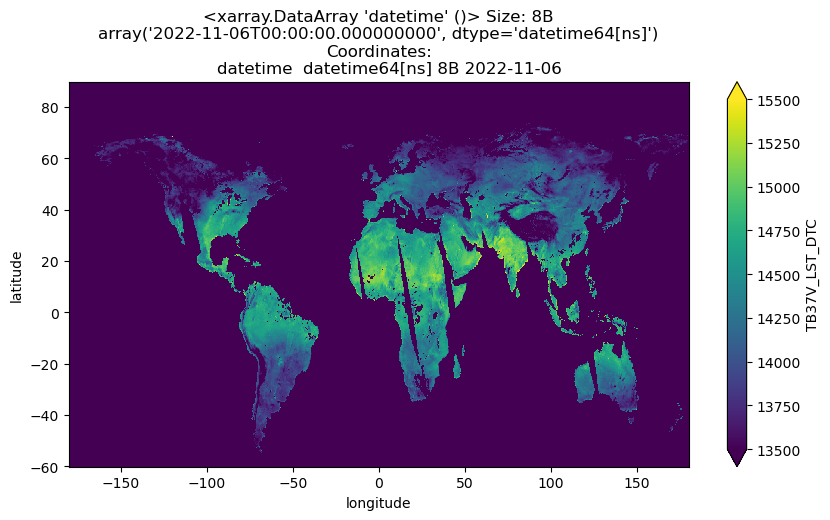

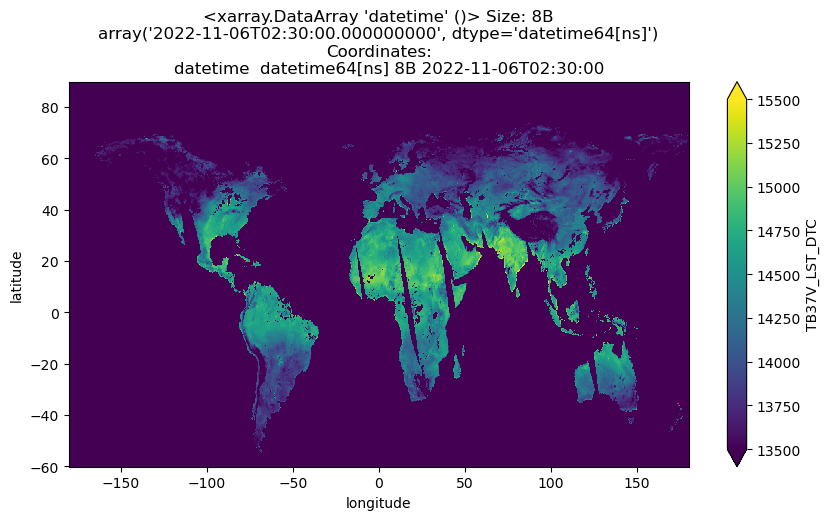

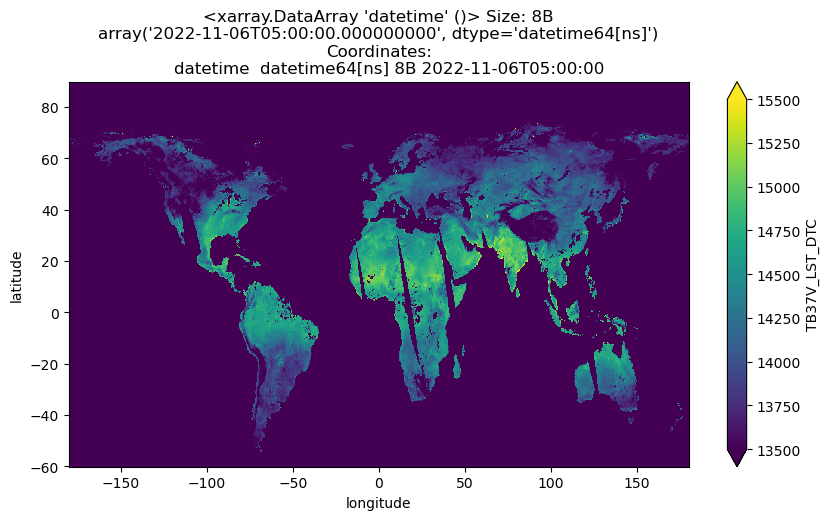

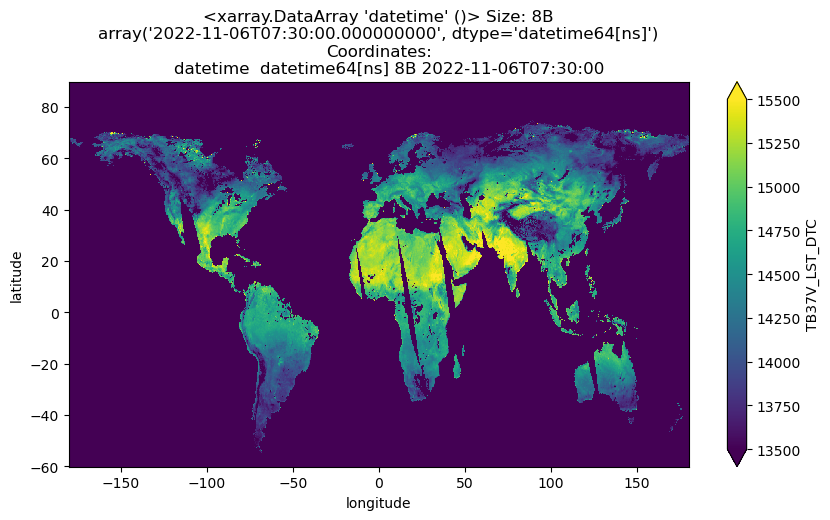

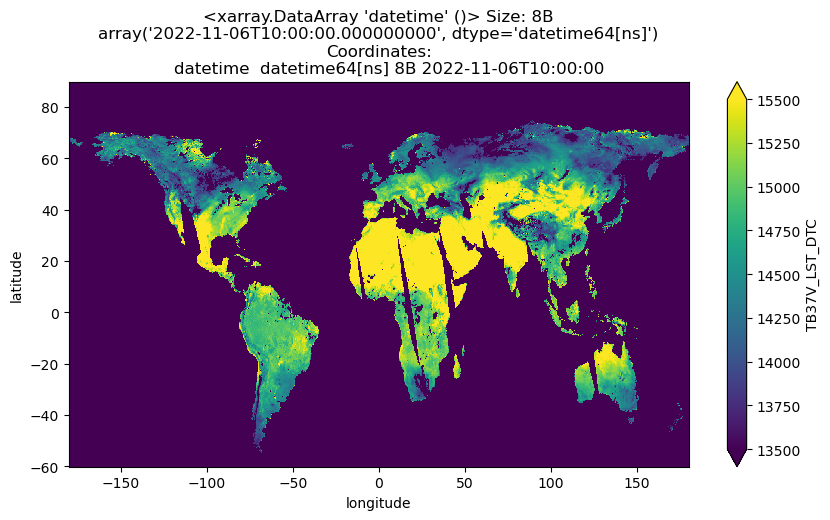

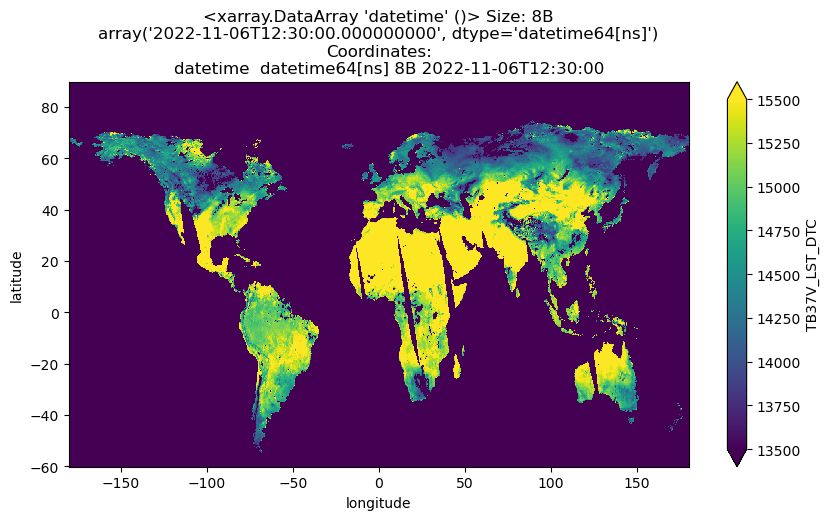

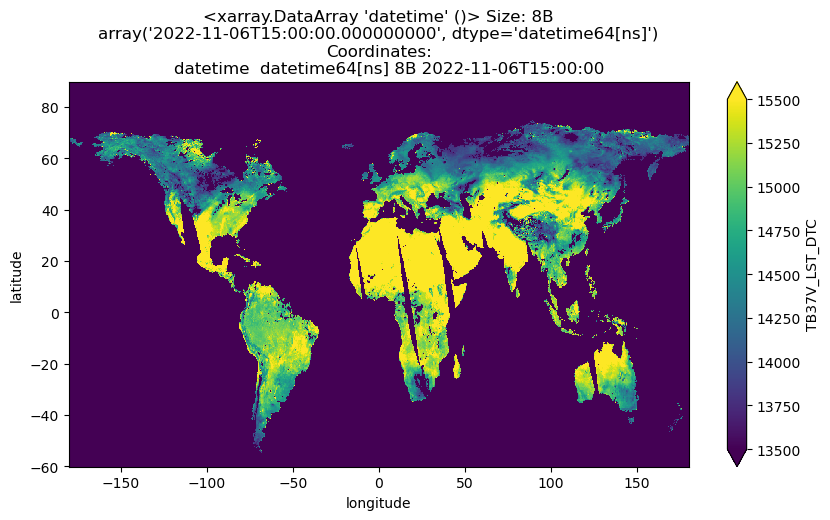

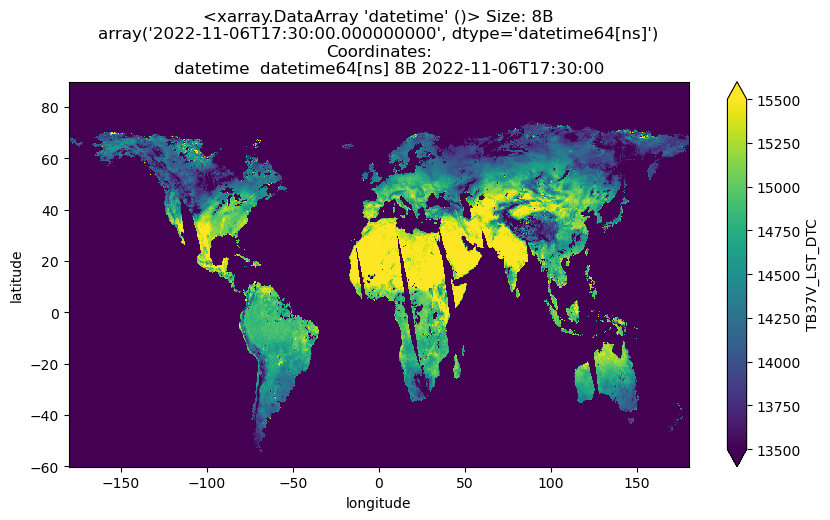

In [29]:
for i in list(range(0, 80, 10)):
    #cb = plt.pcolormesh(dsMW['TB37V_LST_DTC'][i], vmin=13000, vmax=15000)
    dsMW['TB37V_LST_DTC'].isel(phony_dim_0=i).plot.pcolormesh("longitude", "latitude", vmin=13500, vmax=15500, figsize=(10,5))
    #plt.colorbar(cb)
    plt.title(dsMW['datetime'][i])
    #if i%24 == 0:
        #plt.savefig(f'../../photos/mw_{i}.jpg')
    plt.show()

In [41]:
np.max(latlon_pts_2km[:,:,0]), np.min(latlon_pts_2km[:,:,0]), np.max(latlon_pts_2km[:,:,1]), np.min(latlon_pts_2km[:,:,1])

(np.float64(-83.82099010261425),
 np.float64(-84.79545361222962),
 np.float64(34.2038764910845),
 np.float64(33.39037178734117))

In [42]:
def get_next_latlon_coord(n, above=True):
    if above:
        return np.ceil(n*4)/4
    else:
        return np.floor(n*4)/4

In [43]:
np.where(dsMW['latitude'] == 38.5)[0][0]

np.int64(205)

In [44]:
np.where(dsMW['latitude'] == get_next_latlon_coord(np.min(latlon_pts_2km[:,:,1]), False))[0][0]

np.int64(226)

In [45]:
max_lon_index = np.where(dsMW['longitude'] == get_next_latlon_coord(np.max(latlon_pts_2km[:,:,0]), True))[0][0]
min_lon_index = np.where(dsMW['longitude'] == get_next_latlon_coord(np.min(latlon_pts_2km[:,:,0]), False))[0][0]
max_lat_index = np.where(dsMW['latitude'] == get_next_latlon_coord(np.max(latlon_pts_2km[:,:,1]), True))[0][0]
min_lat_index = np.where(dsMW['latitude'] == get_next_latlon_coord(np.min(latlon_pts_2km[:,:,1]), False))[0][0]

In [47]:
date_format = "%Y-%m-%dT%H:%M:%SZ"
time = '2023-01-05T01:00:00Z'
utc_dt = datetime.datetime.strptime(time, date_format)
#local_dt = utc_dt + datetime.timedelta(hours=(longitude/360)*24)
#date_str = f'{local_dt.year}{stringify(local_dt.month)}{stringify(local_dt.day)}'
#time_index = local_dt.hour*4 + round(local_dt.minute/15+local_dt.second/3600)

In [48]:
def time_adjust(longitude, dt=utc_dt):
    local_dt = dt + datetime.timedelta(hours=(longitude/360)*24) # Adjusting for global local time
    time_index = local_dt.hour*4 + round(local_dt.minute/15+local_dt.second/3600) # Used in selection of datetime index from mw file (every 15 minutes)
    return time_index

In [49]:
func = np.vectorize(time_adjust)
time_indices = func(latlon_pts_2km[:,:,0])
time_indices

array([[77, 77, 77, ..., 78, 78, 78],
       [77, 77, 77, ..., 78, 78, 78],
       [77, 77, 77, ..., 78, 78, 78],
       ...,
       [77, 77, 77, ..., 78, 78, 78],
       [77, 77, 77, ..., 78, 78, 78],
       [77, 77, 77, ..., 78, 78, 78]], shape=(45, 45))

In [50]:
mw_clipped = dsMW['TB37V_LST_DTC'][np.min(time_indices):np.max(time_indices)+1,min_lon_index:max_lon_index+1,max_lat_index:min_lat_index+1]
mw_clipped

<xarray.DataArray 'TB37V_LST_DTC' (phony_dim_0: 2, phony_dim_1: 6,
                                   phony_dim_2: 5)> Size: 120B
[60 values with dtype=uint16]
Coordinates:
    datetime   (phony_dim_0) datetime64[ns] 16B 2022-11-06T19:15:00 2022-11-0...
    longitude  (phony_dim_1) float64 48B -85.0 -84.75 -84.5 -84.25 -84.0 -83.75
    latitude   (phony_dim_2) float64 40B 34.25 34.0 33.75 33.5 33.25
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Attributes:
    Gain:     50.0
    NoData:   0.0
    Offset:   0.0

In [51]:
mw_clipped[1].T.values/50

array([[296.38, 295.08, 294.56, 295.16, 298.16, 295.82],
       [296.38, 296.84, 296.44, 296.6 , 297.36, 296.56],
       [295.72, 297.44, 298.2 , 297.78, 296.86, 297.  ],
       [295.76, 296.36, 297.98, 296.6 , 296.78, 296.7 ],
       [295.54, 296.3 , 296.54, 296.68, 296.36, 295.82]])

In [59]:
y, x = np.meshgrid(mw_clipped['latitude'], mw_clipped['longitude'])
mw_latlons = np.stack((x,y)).T.reshape(-1,2)
mw_latlons

array([[-85.  ,  34.25],
       [-84.75,  34.25],
       [-84.5 ,  34.25],
       [-84.25,  34.25],
       [-84.  ,  34.25],
       [-83.75,  34.25],
       [-85.  ,  34.  ],
       [-84.75,  34.  ],
       [-84.5 ,  34.  ],
       [-84.25,  34.  ],
       [-84.  ,  34.  ],
       [-83.75,  34.  ],
       [-85.  ,  33.75],
       [-84.75,  33.75],
       [-84.5 ,  33.75],
       [-84.25,  33.75],
       [-84.  ,  33.75],
       [-83.75,  33.75],
       [-85.  ,  33.5 ],
       [-84.75,  33.5 ],
       [-84.5 ,  33.5 ],
       [-84.25,  33.5 ],
       [-84.  ,  33.5 ],
       [-83.75,  33.5 ],
       [-85.  ,  33.25],
       [-84.75,  33.25],
       [-84.5 ,  33.25],
       [-84.25,  33.25],
       [-84.  ,  33.25],
       [-83.75,  33.25]])

In [54]:
interpolated_arrays = []
for arr in mw_clipped:
    mw_interpolated = interpolate.griddata(mw_latlons, arr.T.values.reshape(-1)/50, latlon_pts_2km, method='nearest')
    interpolated_arrays.append(mw_interpolated)
interpolated_array = np.stack(interpolated_arrays)

In [55]:
interpolated_array

array([[[295.4 , 295.4 , 295.4 , ..., 296.28, 296.28, 296.28],
        [295.4 , 295.4 , 295.4 , ..., 296.28, 296.28, 296.28],
        [295.4 , 295.4 , 295.4 , ..., 296.28, 296.28, 296.28],
        ...,
        [296.78, 296.78, 296.78, ..., 297.24, 297.16, 297.16],
        [296.78, 296.78, 296.78, ..., 297.24, 297.16, 297.16],
        [296.78, 296.78, 296.78, ..., 297.24, 297.16, 297.16]],

       [[295.08, 295.08, 295.08, ..., 295.82, 295.82, 295.82],
        [295.08, 295.08, 295.08, ..., 295.82, 295.82, 295.82],
        [295.08, 295.08, 295.08, ..., 295.82, 295.82, 295.82],
        ...,
        [296.36, 296.36, 296.36, ..., 296.78, 296.7 , 296.7 ],
        [296.36, 296.36, 296.36, ..., 296.78, 296.7 , 296.7 ],
        [296.36, 296.36, 296.36, ..., 296.78, 296.7 , 296.7 ]]],
      shape=(2, 45, 45))

In [56]:
interpolated_indices = time_indices-np.min(time_indices)
interpolated_indices

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], shape=(45, 45))

In [57]:
# Index the first dimension of the value array
mw_interpolated = interpolated_array[interpolated_indices, np.arange(45)[:, None], np.arange(45)]
mw_interpolated

array([[295.4 , 295.4 , 295.4 , ..., 295.82, 295.82, 295.82],
       [295.4 , 295.4 , 295.4 , ..., 295.82, 295.82, 295.82],
       [295.4 , 295.4 , 295.4 , ..., 295.82, 295.82, 295.82],
       ...,
       [296.78, 296.78, 296.78, ..., 296.78, 296.7 , 296.7 ],
       [296.78, 296.78, 296.78, ..., 296.78, 296.7 , 296.7 ],
       [296.78, 296.78, 296.78, ..., 296.78, 296.7 , 296.7 ]],
      shape=(45, 45))

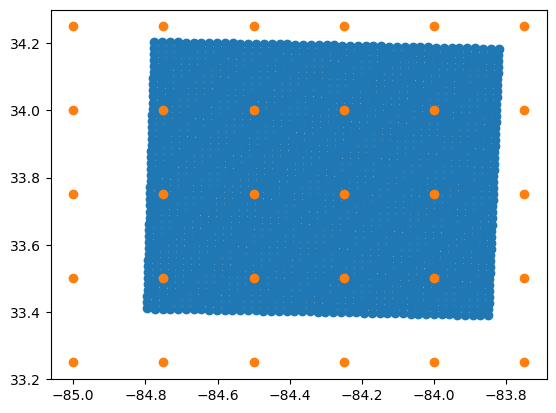

In [65]:
plt.scatter(latlon_pts_2km[:,:,0], latlon_pts_2km[:,:,1])
plt.scatter(mw_latlons[:,0], mw_latlons[:,1])

In [66]:
geotiff_dsG['microwave_LST'] = (('y','x'), mw_interpolated)

In [67]:
geotiff_dsG = geotiff_dsG.reindex(y=geotiff_dsG.y[::-1])

In [68]:
geotiff_dsG

<xarray.Dataset> Size: 82kB
Dimensions:        (x: 45, y: 45)
Coordinates:
  * x              (x) float64 360B 7.05e+05 7.07e+05 ... 7.91e+05 7.93e+05
  * y              (y) float64 360B 3.699e+06 3.701e+06 ... 3.785e+06 3.787e+06
    spatial_ref    int64 8B 0
    datetime       <U20 80B '2022-05-20T03:00:20Z'
Data variables:
    GOES_C13_LWIR  (y, x) float64 16kB ...
    GOES_C14_LWIR  (y, x) float64 16kB ...
    GOES_C15_LWIR  (y, x) float64 16kB ...
    GOES_C16_LWIR  (y, x) float64 16kB 268.7 268.5 268.4 ... 269.7 269.3 269.2
    microwave_LST  (y, x) float64 16kB 296.8 296.8 296.8 ... 295.8 295.8 295.8
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              0.0
    scale_factor:            1.0
    add_offset:              0.0

In [69]:
# Add metadata
geotiff_dsG['GOES_C13_LWIR'].attrs['standard_name'] = 'toa_brightness_temperature'
geotiff_dsG['GOES_C13_LWIR'].attrs['units'] = 'K'
geotiff_dsG['GOES_C13_LWIR'].attrs['valid_min'] = 89.62
geotiff_dsG['GOES_C13_LWIR'].attrs['valid_max'] = 341.27
geotiff_dsG['GOES_C13_LWIR'].attrs['missing_value'] = np.nan
geotiff_dsG['GOES_C13_LWIR'].attrs['wavelength'] = '10.1-10.6 µm'

geotiff_dsG['GOES_C14_LWIR'].attrs['standard_name'] = 'toa_brightness_temperature'
geotiff_dsG['GOES_C14_LWIR'].attrs['units'] = 'K'
geotiff_dsG['GOES_C14_LWIR'].attrs['valid_min'] = 96.19
geotiff_dsG['GOES_C14_LWIR'].attrs['valid_max'] = 341.28
geotiff_dsG['GOES_C14_LWIR'].attrs['missing_value'] = np.nan
geotiff_dsG['GOES_C14_LWIR'].attrs['wavelength'] = '10.8-11.6 µm'

geotiff_dsG['GOES_C15_LWIR'].attrs['standard_name'] = 'toa_brightness_temperature'
geotiff_dsG['GOES_C15_LWIR'].attrs['units'] = 'K'
geotiff_dsG['GOES_C15_LWIR'].attrs['valid_min'] = 97.38
geotiff_dsG['GOES_C15_LWIR'].attrs['valid_max'] = 341.28
geotiff_dsG['GOES_C15_LWIR'].attrs['missing_value'] = np.nan
geotiff_dsG['GOES_C15_LWIR'].attrs['wavelength'] = '11.8-12.8 µm'

geotiff_dsG['GOES_C16_LWIR'].attrs['standard_name'] = 'toa_brightness_temperature'
geotiff_dsG['GOES_C16_LWIR'].attrs['units'] = 'K'
geotiff_dsG['GOES_C16_LWIR'].attrs['valid_min'] = 92.7
geotiff_dsG['GOES_C16_LWIR'].attrs['valid_max'] = 318.26
geotiff_dsG['GOES_C16_LWIR'].attrs['missing_value'] = np.nan
geotiff_dsG['GOES_C16_LWIR'].attrs['wavelength'] = '13.0-13.6 µm'

geotiff_dsG['microwave_LST'].attrs['standard_name'] = 'surface_temperature'
geotiff_dsG['microwave_LST'].attrs['units'] = 'K'
geotiff_dsG['microwave_LST'].attrs['missing_value'] = np.nan
geotiff_dsG['microwave_LST'].attrs['wavelength'] = '0.81-0.83 cm'
geotiff_dsG['microwave_LST'].attrs['grid_mapping'] = 'spatial_ref'

In [70]:
geotiff_dsG['y'].attrs['standard_name'] = 'projection_y_coordinate'
geotiff_dsG['y'].attrs['long_name'] = 'UTM Northing'
geotiff_dsG['y'].attrs['units'] = 'm'

geotiff_dsG['x'].attrs['standard_name'] = 'projection_x_coordinate'
geotiff_dsG['x'].attrs['long_name'] = 'UTM Easting'
geotiff_dsG['x'].attrs['units'] = 'm'

geotiff_dsG['datetime'].attrs['long_name'] = 'datetime'
geotiff_dsG['datetime'].attrs['units'] = 'YYYY-mm-DDTHH:MM:SSZ'
geotiff_dsG['datetime'].attrs['calendar'] = 'utc'

In [71]:
if city in ['Seattle', 'San_Francisco', 'Los_Angeles', 'San_Diego', 'Phoenix', 'Las_Vegas', 'Salt_Lake_City']:
    geotiff_dsG.attrs['title'] = f'GOES-17/18 and microwave LST data for {city_str_dict[city]}'
else:
    geotiff_dsG.attrs['title'] = f'GOES-16 and microwave_LST data for {city_str_dict[city]}'
geotiff_dsG.attrs['institution'] = 'University of Maryland, College Park'
geotiff_dsG.attrs['source'] = 'Satellite observation'

In [72]:
del geotiff_dsG.attrs['TIFFTAG_XRESOLUTION']
del geotiff_dsG.attrs['TIFFTAG_YRESOLUTION']
del geotiff_dsG.attrs['TIFFTAG_RESOLUTIONUNIT']
del geotiff_dsG.attrs['_FillValue']

In [73]:
geotiff_dsG

<xarray.Dataset> Size: 82kB
Dimensions:        (x: 45, y: 45)
Coordinates:
  * x              (x) float64 360B 7.05e+05 7.07e+05 ... 7.91e+05 7.93e+05
  * y              (y) float64 360B 3.699e+06 3.701e+06 ... 3.785e+06 3.787e+06
    spatial_ref    int64 8B 0
    datetime       <U20 80B '2022-05-20T03:00:20Z'
Data variables:
    GOES_C13_LWIR  (y, x) float64 16kB ...
    GOES_C14_LWIR  (y, x) float64 16kB ...
    GOES_C15_LWIR  (y, x) float64 16kB ...
    GOES_C16_LWIR  (y, x) float64 16kB 268.7 268.5 268.4 ... 269.7 269.3 269.2
    microwave_LST  (y, x) float64 16kB 296.8 296.8 296.8 ... 295.8 295.8 295.8
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    title:          GOES-16 and microwave_LST data for Atlanta, Georgia, USA
    institution:    University of Maryland, College Park
    source:         Satellite observation

## Export and re-open

In [74]:
# Export the data
#geotiff_dsLS.rio.to_raster("../../Landsat_Sentinel_DMV_processed/Landsat_sample.tif")
#geotiff_dsG.rio.to_raster("../../Landsat_Sentinel_DMV_processed/GOES_sample.tif")
#geotiff_dsG.to_netcdf("/home/jonstar/scratch/GOES_sample.nc")
geotiff_dsG.to_netcdf("/glade/derecho/scratch/jstarfeldt/GOES_sample.nc")

In [75]:
xr.open_dataset("/glade/derecho/scratch/jstarfeldt/GOES_sample.nc")

<xarray.Dataset> Size: 82kB
Dimensions:        (y: 45, x: 45)
Coordinates:
  * x              (x) float64 360B 7.05e+05 7.07e+05 ... 7.91e+05 7.93e+05
  * y              (y) float64 360B 3.699e+06 3.701e+06 ... 3.785e+06 3.787e+06
    datetime       object 8B ...
Data variables:
    GOES_C13_LWIR  (y, x) float64 16kB ...
    GOES_C14_LWIR  (y, x) float64 16kB ...
    GOES_C15_LWIR  (y, x) float64 16kB ...
    GOES_C16_LWIR  (y, x) float64 16kB ...
    microwave_LST  (y, x) float64 16kB ...
    spatial_ref    int32 4B ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    title:          GOES-16 and microwave_LST data for Atlanta, Georgia, USA
    institution:    University of Maryland, College Park
    source:         Satellite observation

## Processing Functions

In [7]:
city_str_dict = {
    'Atlanta': 'Atlanta, Georgia, USA',
    'Billings': 'Billings, Montana, USA',
    'Bogota': 'Bogota, Colombia',
    'Brasilia': 'Brasilia, Brazil',
    'Buenos_Aires': 'Buenos Aires, Argentina',
    'Cancun': 'Cancun, Mexico',
    'Caracas': 'Caracas, Venezuela',
    'Charlotte': 'Charlotte, North Carolina, USA',
    'Chicago': 'Chicago, Illinois, USA',
    'Dallas': 'Dallas, Texas, USA and Fort Worth, Texas, USA',
    'Denver': 'Denver, Colorado, USA',
    'Guadalajara': 'Guadalajara, Mexico',
    'Guatemala_City': 'Guatemala City, Guatemala',
    'Havana': 'Havana, Cuba',
    'Houston': 'Houston, Texas, USA',
    'Jacksonville': 'Jacksonville, Florida, USA',
    'La_Paz': 'La Paz, Bolivia',
    'Las_Vegas': 'Las Vegas, Nevada, USA',
    'Lima': 'Lima, Peru',
    'Los_Angeles': 'Los Angeles, California, USA',
    'Managua': 'Managua, Nicaragua',
    'Manaus': 'Manaus, Brazil',
    'Mexico_City': 'Mexico City, Mexico',
    'Miami': 'Miami, Florida, USA',
    'Minneapolis': 'Minneapolis, Minnesota, USA',
    'Monterrey': 'Monterrey, Mexico',
    'Montevideo': 'Montevideo, Uruguay',
    'Montreal': 'Montreal, Quebec, Canada',
    'New_Orleans': 'New Orleans, Louisiana, USA',
    'NYC': 'New York City, New York, USA',
    'Panama_City': 'Panama City, Panama',
    'Philadelphia': 'Philadelphia, Pennsylvania, USA',
    'Phoenix': 'Phoenix, Arizona, USA',
    'Punta_Arenas': 'Punta Arenas, Chile',
    'Quito': 'Quito, Ecuador',
    'Salt_Lake_City': 'Salt Lake City, Utah, USA',
    'San_Diego': 'San Diego, California, USA and Tijuana, Mexico',
    'San_Francisco': 'San Francisco, California, USA and San Jose, California, USA',
    'San_Jose': 'San Jose, Costa Rica',
    'San_Juan': 'San Juan, Puerto Rico',
    'Santiago': 'Santiago, Chile',
    'Santo_Domingo': 'Santo Domingo, Dominican Republic',
    'Sao_Paulo': 'Sao Paulo, Brazil',
    'Seattle': 'Seattle, Washington, USA',
    'St_Louis': 'St Louis, Missouri, USA',
    'Tegucigalpa': 'Tegucigalpa, Honduras',
    'Toronto': 'Toronto, Ontario, USA',
    'DMV': 'Washington, DC, USA and Baltimore, Maryland, USA'
}

### Landsat

In [8]:
def sort_func_Landsat(s, form=int):
    if form == int:
        return int(s.split(f'{city}_')[1].split('.tif')[0])
    else:
        return str(s.split(f'{city}_')[1].split('.tif')[0])

In [9]:
"""
Processing of individual .tif files.

Performs a variety of tasks on the data to make it more easy to read and understand.

Attributes:
    tif (str): Path where tif file is located.
    time (str): Date and time of when the data was collected format YYYY-MM-DDThh:mm:ssZ.
    coord_bounds (tuple or list, optional): Coordinate bounds if you wish to filter the data by location. Order should be
                                    (longitude minimum, longitude maximum, latitude minimum, latitude maximum).
"""
def process_Landsat_Sentinel_tif(tif, time, coord_bounds=None):
    #########################################################################################################
    # Open file and rename variables
    dsLS = rxr.open_rasterio(tif)[:,:3000,:3000] 
    dsLS = dsLS.reindex(y=dsLS.y[::-1]) # Invert y-axis so that values are increasing instead of decreasing with index
    geotiff_ds = dsLS.to_dataset('band')

    geotiff_ds = geotiff_ds.rename({1:'Landsat_blue_sfc_reflectance', 2:'Landsat_green_sfc_reflectance',
                                    3:'Landsat_red_sfc_reflectance', 4:'Landsat_NIR_sfc_reflectance',
                                    5:'Landsat_SWIR1_sfc_reflectance', 6:'Landsat_SWIR2_sfc_reflectance',
                                    7:'Landsat_LST', 8:'Landsat_cloud_mask', 9:'Sentinel1_VV', 10:'Sentinel1_VH', 11:'Sentinel1_HH',
                                    12:'Sentinel1_HV', 13:'Sentinel1_incidence_angle'})
    geotiff_ds = geotiff_ds.assign_coords({'datetime':time})
    del geotiff_ds.attrs['long_name']

    #########################################################################################################
    # Convert cloud mask integers to binary strings
    binary_vectorized = np.vectorize(to_binary_string)
    mask = binary_vectorized(geotiff_ds.Landsat_cloud_mask.values)
    geotiff_ds['Landsat_cloud_mask'].values = mask

    # Filter anomalous values from Sentinel-1 variables and set them to nan
    for variable in ['Sentinel1_VV', 'Sentinel1_VH', 'Sentinel1_HH', 'Sentinel1_HV']:
        geotiff_ds[variable].values = np.where(geotiff_ds[variable].values > 1, np.nan, geotiff_ds[variable].values)
    geotiff_ds['Sentinel1_incidence_angle'].values = np.where(geotiff_ds['Sentinel1_incidence_angle'].values < 0,
                                                      np.nan, geotiff_ds['Sentinel1_incidence_angle'].values)

    #########################################################################################################
    # Assign descriptive attributes for the cloud mask and a new coordinate for the file datetime
    if 'Landsat9' in tif:
        geotiff_ds.attrs['title'] = f'Landsat 9 and Sentinel-1 data for {city_str_dict[city]}'
    else:
        geotiff_ds.attrs['title'] = f'Landsat 8 and Sentinel-1 data for {city_str_dict[city]}'
    geotiff_ds.attrs['institution'] = 'University of Maryland, College Park'
    geotiff_ds.attrs['source'] = 'Satellite observation'

    geotiff_ds['y'].attrs['standard_name'] = 'projection_y_coordinate'
    geotiff_ds['y'].attrs['long_name'] = 'UTM Northing'
    geotiff_ds['y'].attrs['units'] = 'm'
    
    geotiff_ds['x'].attrs['standard_name'] = 'projection_x_coordinate'
    geotiff_ds['x'].attrs['long_name'] = 'UTM Easting'
    geotiff_ds['x'].attrs['units'] = 'm'

    geotiff_ds['datetime'].attrs['long_name'] = 'datetime'
    geotiff_ds['datetime'].attrs['units'] = 'YYYY-mm-DDTHH:MM:SSZ'
    geotiff_ds['datetime'].attrs['calendar'] = 'utc'
    
    geotiff_ds['Landsat_blue_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
    geotiff_ds['Landsat_blue_sfc_reflectance'].attrs['units'] = '1'
    geotiff_ds['Landsat_blue_sfc_reflectance'].attrs['valid_min'] = 0
    geotiff_ds['Landsat_blue_sfc_reflectance'].attrs['valid_max'] = 1
    geotiff_ds['Landsat_blue_sfc_reflectance'].attrs['missing_value'] = np.nan
    geotiff_ds['Landsat_blue_sfc_reflectance'].attrs['wavelength'] = '0.452-0.512 μm'
    
    geotiff_ds['Landsat_green_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
    geotiff_ds['Landsat_green_sfc_reflectance'].attrs['units'] = '1'
    geotiff_ds['Landsat_green_sfc_reflectance'].attrs['valid_min'] = 0
    geotiff_ds['Landsat_green_sfc_reflectance'].attrs['valid_max'] = 1
    geotiff_ds['Landsat_green_sfc_reflectance'].attrs['missing_value'] = np.nan
    geotiff_ds['Landsat_green_sfc_reflectance'].attrs['wavelength'] = '0.533-0.590 μm'
    
    geotiff_ds['Landsat_red_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
    geotiff_ds['Landsat_red_sfc_reflectance'].attrs['units'] = '1'
    geotiff_ds['Landsat_red_sfc_reflectance'].attrs['valid_min'] = 0
    geotiff_ds['Landsat_red_sfc_reflectance'].attrs['valid_max'] = 1
    geotiff_ds['Landsat_red_sfc_reflectance'].attrs['missing_value'] = np.nan
    geotiff_ds['Landsat_red_sfc_reflectance'].attrs['wavelength'] = '0.636-0.673 μm'
    
    geotiff_ds['Landsat_NIR_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
    geotiff_ds['Landsat_NIR_sfc_reflectance'].attrs['units'] = '1'
    geotiff_ds['Landsat_NIR_sfc_reflectance'].attrs['valid_min'] = 0
    geotiff_ds['Landsat_NIR_sfc_reflectance'].attrs['valid_max'] = 1
    geotiff_ds['Landsat_NIR_sfc_reflectance'].attrs['missing_value'] = np.nan
    geotiff_ds['Landsat_NIR_sfc_reflectance'].attrs['wavelength'] = '0.851-0.879 μm'
    
    geotiff_ds['Landsat_SWIR1_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
    geotiff_ds['Landsat_SWIR1_sfc_reflectance'].attrs['units'] = '1'
    geotiff_ds['Landsat_SWIR1_sfc_reflectance'].attrs['valid_min'] = 0
    geotiff_ds['Landsat_SWIR1_sfc_reflectance'].attrs['valid_max'] = 1
    geotiff_ds['Landsat_SWIR1_sfc_reflectance'].attrs['missing_value'] = np.nan
    geotiff_ds['Landsat_SWIR1_sfc_reflectance'].attrs['wavelength'] = '1.566-1.651 μm'
    
    geotiff_ds['Landsat_SWIR2_sfc_reflectance'].attrs['standard_name'] = 'surface_bidirectional_reflectance'
    geotiff_ds['Landsat_SWIR2_sfc_reflectance'].attrs['units'] = '1'
    geotiff_ds['Landsat_SWIR2_sfc_reflectance'].attrs['valid_min'] = 0
    geotiff_ds['Landsat_SWIR2_sfc_reflectance'].attrs['valid_max'] = 1
    geotiff_ds['Landsat_SWIR2_sfc_reflectance'].attrs['missing_value'] = np.nan
    geotiff_ds['Landsat_SWIR2_sfc_reflectance'].attrs['wavelength'] = '2.107-2.294 μm'
    
    geotiff_ds['Landsat_LST'].attrs['standard_name'] = 'surface_temperature'
    geotiff_ds['Landsat_LST'].attrs['units'] = 'K'
    geotiff_ds['Landsat_LST'].attrs['valid_min'] = 0
    geotiff_ds['Landsat_LST'].attrs['valid_max'] = 373
    geotiff_ds['Landsat_LST'].attrs['wavelength'] = '10.60-11.19 μm'
    geotiff_ds['Landsat_LST'].attrs['missing_value'] = np.nan
    
    geotiff_ds['Landsat_cloud_mask'].attrs['long_name'] = 'pixel quality mask'
    geotiff_ds['Landsat_cloud_mask'].attrs['bitmask_key'] = \
    "Bit 0: Fill\n\
    Bit 1: Dilated Cloud\n\
    Bit 2: Cirrus (high confidence)\n\
    Bit 3: Cloud\n\
    Bit 4: Cloud Shadow\n\
    Bit 5: Snow\n\
    Bit 6: Clear\n\t0: Cloud or Dilated Cloud bits are set\n\t1: Cloud and Dilated Cloud bits are not set\n\
    Bit 7: Water\n\
    Bits 8-9: Cloud Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
    Bits 10-11: Cloud Shadow Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
    Bits 12-13: Snow/Ice Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High\n\
    Bits 14-15: Cirrus Confidence\n\t0: None\n\t1: Low\n\t2: Medium\n\t3: High"
    
    geotiff_ds['Sentinel1_VV'].attrs['standard_name'] = 'surface_backwards_scattering_coefficient_of_radar_wave'
    geotiff_ds['Sentinel1_VV'].attrs['units'] = 'dB'
    geotiff_ds['Sentinel1_VV'].attrs['valid_max'] = 1
    geotiff_ds['Sentinel1_VV'].attrs['wavelength'] = '5.55 cm'
    geotiff_ds['Sentinel1_VV'].attrs['missing_value'] = np.nan
    
    geotiff_ds['Sentinel1_VH'].attrs['standard_name'] = 'surface_backwards_scattering_coefficient_of_radar_wave'
    geotiff_ds['Sentinel1_VH'].attrs['units'] = 'dB'
    geotiff_ds['Sentinel1_VH'].attrs['valid_max'] = 1
    geotiff_ds['Sentinel1_VH'].attrs['wavelength'] = '5.55 cm'
    geotiff_ds['Sentinel1_VH'].attrs['missing_value'] = np.nan
    
    geotiff_ds['Sentinel1_HH'].attrs['standard_name'] = 'surface_backwards_scattering_coefficient_of_radar_wave'
    geotiff_ds['Sentinel1_HH'].attrs['units'] = 'dB'
    geotiff_ds['Sentinel1_HH'].attrs['valid_max'] = 1
    geotiff_ds['Sentinel1_HH'].attrs['wavelength'] = '5.55 cm'
    geotiff_ds['Sentinel1_HH'].attrs['missing_value'] = np.nan
    
    geotiff_ds['Sentinel1_HV'].attrs['standard_name'] = 'surface_backwards_scattering_coefficient_of_radar_wave'
    geotiff_ds['Sentinel1_HV'].attrs['units'] = 'dB'
    geotiff_ds['Sentinel1_HV'].attrs['valid_max'] = 1
    geotiff_ds['Sentinel1_HV'].attrs['wavelength'] = '5.55 cm'
    geotiff_ds['Sentinel1_HV'].attrs['missing_value'] = np.nan
    
    geotiff_ds['Sentinel1_incidence_angle'].attrs['standard_name'] = 'angle_of_incidence'
    geotiff_ds['Sentinel1_incidence_angle'].attrs['units'] = 'degree'
    geotiff_ds['Sentinel1_incidence_angle'].attrs['valid_min'] = 0
    geotiff_ds['Sentinel1_incidence_angle'].attrs['valid_max'] = 90
    geotiff_ds['Sentinel1_incidence_angle'].attrs['missing_value'] = np.nan
    
    #########################################################################################################
    # Optional filtering by lat/lon
    if coord_bounds:
        geotiff_ds = geotiff_ds.sel(longitude=slice(coord_bounds[0], coord_bounds[1])).sel(latitude=slice(coord_bounds[3], coord_bounds[2]))

    #########################################################################################################
    return geotiff_ds

In [20]:
dt = datetime.datetime.fromtimestamp(times_Landsat[10]/1000, datetime.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = process_Landsat_Sentinel_tif(Landsat_tif_list[10], dt)
ds

<xarray.Dataset> Size: 1GB
Dimensions:                        (y: 3000, x: 3000)
Coordinates:
  * x                              (x) float64 24kB 4.729e+05 ... 5.629e+05
  * y                              (y) float64 24kB 3.848e+06 ... 3.938e+06
    spatial_ref                    int64 8B 0
    datetime                       <U20 80B '2022-06-23T15:59:51Z'
Data variables: (12/13)
    Landsat_blue_sfc_reflectance   (y, x) float64 72MB ...
    Landsat_green_sfc_reflectance  (y, x) float64 72MB ...
    Landsat_red_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_NIR_sfc_reflectance    (y, x) float64 72MB ...
    Landsat_SWIR1_sfc_reflectance  (y, x) float64 72MB ...
    Landsat_SWIR2_sfc_reflectance  (y, x) float64 72MB ...
    ...                             ...
    Landsat_cloud_mask             (y, x) <U16 576MB '1101011100001100' ... '...
    Sentinel1_VV                   (y, x) float64 72MB -11.09 -12.1 ... -10.68
    Sentinel1_VH                   (y, x) float64 72MB -15.8 -16.65 ... -19.58
    Sentinel1_HH                   (y, x) float64 72MB nan nan nan ... nan nan
    Sentinel1_HV                   (y, x) float64 72MB nan nan nan ... nan nan
    Sentinel1_incidence_angle      (y, x) float64 72MB 34.61 34.61 ... 41.04
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    title:          Landsat 9 and Sentinel-1 data for Charlotte, North Caroli...
    institution:    University of Maryland, College Park
    source:         Satellite observation

In [10]:
city = cities[46]
print(city)

Tegucigalpa


In [11]:
# Runs processing function on all the geotif files
for city in cities[46:]:
    processed_dir = f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/{city}/processed_Landsat'
    times_Landsat = pd.read_csv(f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Landsat_times/Landsat9_times_{city}.csv').value
    Landsat_root = f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/{city}/Landsat'
    Landsat_tif_list = glob.glob(Landsat_root+'/*.tif')
    Landsat_tif_list = sorted(Landsat_tif_list, key=sort_func_Landsat)
    
    
    for i in range(len(Landsat_tif_list)):
        fname = Landsat_tif_list[i].split('/')[-1].split('.')[0]
        dt = datetime.datetime.fromtimestamp(times_Landsat[i]/1000, datetime.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
        ds = process_Landsat_Sentinel_tif(Landsat_tif_list[i], dt)
        ds.to_netcdf(f'{processed_dir}/{fname}.nc')

### GOES

In [102]:
"""
Processing of individual .tif files.

Performs a variety of tasks on the data to make it more easy to read and understand.

Attributes:
    tif (str): Path where tif file is located.
    time (str): Date and time of when the data was collected format YYYY-MM-DDThh:mm:ssZ.
    latlon_pts (float array): (45,45,2) Array of (longitude, latitude) points at each point on the utm grid.
    local_timezone (pytz timezone): Local timezone of the area you are creating data for
    coord_bounds (tuple or list, optional): Coordinate bounds if you wish to filter the data by location. Order should be
                                    (longitude minimum, longitude maximum, latitude minimum, latitude maximum).
"""
def process_GOES_tif(tif, time, latlon_pts, coord_bounds=None):
    #########################################################################################################
    # Open file and rename variables
    dsG = rxr.open_rasterio(tif)
    geotiff_ds = dsG.to_dataset('band')
    geotiff_ds = geotiff_ds.rename({1:'GOES_C13_LWIR', 2:'GOES_C14_LWIR',
                                      3:'GOES_C15_LWIR', 4:'GOES_C16_LWIR'})
    geotiff_ds = geotiff_ds.assign_coords({'datetime':time})

    #########################################################################################################
    # Process microwave data
    """
    Returns the value rounded up or down to the nearest 0.25.

    Attributes:
        n (float): latitude or longitude coordinate.
        above (boolean): True for round up, False for round down.
    """
    def get_next_latlon_coord(n, above=True):
        if above:
            return np.ceil(n*4)/4
        else:
            return np.floor(n*4)/4

    """
    Returns an integer as a str, adding a zero in front if it is a single digit.

    Attributes:
        num (int): Integer to turn into a string.
    """
    def stringify(num):
        if num >= 0 and num < 10:
            return f'0{num}'
        else:
            return str(num)

    # Calculate adjusted datetimes for the left and right edges of the image.
    # If the datetimes are across two days, values from two mw LST files need to be used.
    min_longitude = np.min(latlon_pts[:,:,0])
    max_longitude = np.max(latlon_pts[:,:,0])

    date_format = "%Y-%m-%dT%H:%M:%SZ"
    utc_dt = datetime.datetime.strptime(time, date_format)
    local_dt1 = utc_dt + datetime.timedelta(hours=(min_longitude/360)*24)
    date_str1 = f'{local_dt1.year}{stringify(local_dt1.month)}{stringify(local_dt1.day)}'
    local_dt2 = utc_dt + datetime.timedelta(hours=(max_longitude/360)*24)
    date_str2 = f'{local_dt2.year}{stringify(local_dt2.month)}{stringify(local_dt2.day)}'


    """
    Adjusts a datetime in UTC to local time based on how far it is from the Prime Meridian and
    calculates an index 0-96 of which 15-minute interval the time is in a day.

    Attributes:
        longitude (float): Longitude value.
        dt (python datetime object): Datetime with a time in UTC.
    """
    def time_adjust(longitude, dt=utc_dt):
        local_dt = dt + datetime.timedelta(hours=(longitude/360)*24) # Adjusting for global local time
        time_index = local_dt.hour*4 + round(local_dt.minute/15+local_dt.second/3600) # Used in selection of datetime index from mw file (every 15 minutes)
        return time_index

    func = np.vectorize(time_adjust)
    time_indices = func(latlon_pts[:,:,0])

    # Accounting for rounding of values to timestep of following day
    if np.sum(time_indices<96) < 2025: 
        local_dt2 = local_dt2 + datetime.timedelta(days=1)
        date_str2 = f'{local_dt2.year}{stringify(local_dt2.month)}{stringify(local_dt2.day)}'

    # Accounting for files we do not have currently
    if date_str1 == '20211231' or date_str2 == '20211231' or date_str1 == '20220322' or date_str2 == '20220322':
        print('date string identifited')
        return

    if date_str1 != date_str2: # When data spans two days (two different files)
        dsMW = xr.open_dataset(f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/mw_data/MW_LST_DTC_{date_str1}_x1y.h5', engine='h5netcdf')
        dsMW = dsMW.assign_coords(
            datetime=("phony_dim_0", pd.date_range(start=date_str1, periods=96, freq="15min")),
            longitude=("phony_dim_1", np.arange(-180,180,0.25)),
            latitude=("phony_dim_2", np.arange(-60,90,0.25)[::-1]))
 
        dsMW2 = xr.open_dataset(f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/mw_data/MW_LST_DTC_{date_str2}_x1y.h5', engine='h5netcdf')
        dsMW2 = dsMW.assign_coords(
            datetime=("phony_dim_0", pd.date_range(start=date_str2, periods=96, freq="15min")),
            longitude=("phony_dim_1", np.arange(-180,180,0.25)),
            latitude=("phony_dim_2", np.arange(-60,90,0.25)[::-1]))    

        dsMW = xr.concat([dsMW.to_dataarray()[0], dsMW2.to_dataarray()[0]], dim='phony_dim_0') # Concatenate arrays to be continuous
        time_indices = np.where(time_indices>90, time_indices, time_indices+96) # Adjust time indices to be in continuous order
    else:
        dsMW = xr.open_dataset(f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/mw_data/MW_LST_DTC_{date_str1}_x1y.h5', engine='h5netcdf')
        dsMW = dsMW.assign_coords(
            datetime=("phony_dim_0", pd.date_range(start=date_str1, periods=96, freq="15min")),
            longitude=("phony_dim_1", np.arange(-180,180,0.25)),
            latitude=("phony_dim_2", np.arange(-60,90,0.25)[::-1]))


    max_lon_index = np.where(dsMW['longitude'] == get_next_latlon_coord(np.max(latlon_pts[:,:,0]), True))[0][0]
    min_lon_index = np.where(dsMW['longitude'] == get_next_latlon_coord(np.min(latlon_pts[:,:,0]), False))[0][0]
    max_lat_index = np.where(dsMW['latitude'] == get_next_latlon_coord(np.max(latlon_pts[:,:,1]), True))[0][0]
    min_lat_index = np.where(dsMW['latitude'] == get_next_latlon_coord(np.min(latlon_pts[:,:,1]), False))[0][0]

    # Create microwave array for specific area
    # Remember: latitude decreases with index
    if date_str1 != date_str2: # Concatenation removes TB37V_LST_DTC variable
        mw_clipped = dsMW[np.min(time_indices):np.max(time_indices)+1,min_lon_index:max_lon_index+1,max_lat_index:min_lat_index+1]
        dsMW.close()
        dsMW2.close()
    else:
        mw_clipped = dsMW['TB37V_LST_DTC'][np.min(time_indices):np.max(time_indices)+1,min_lon_index:max_lon_index+1,max_lat_index:min_lat_index+1]
        dsMW.close()

    y, x = np.meshgrid(mw_clipped['latitude'], mw_clipped['longitude'])
    mw_latlons = np.stack((x,y)).T.reshape(-1,2)

    interpolated_arrays = []
    for arr in mw_clipped:
        mw_interpolated = interpolate.griddata(mw_latlons, arr.T.values.reshape(-1)/50, latlon_pts, method='nearest')
        interpolated_arrays.append(mw_interpolated)
    interpolated_array = np.stack(interpolated_arrays) # Interpolated microwave values from each time index n of shape (n,45,45)
    interpolated_indices = time_indices-np.min(time_indices) # Array of shape (45,45) that select time indices from the value array
    
    # Index the first dimension of the value array
    mw_interpolated = interpolated_array[interpolated_indices, np.arange(45)[:, None], np.arange(45)]

    geotiff_ds['microwave_LST'] = (('y','x'), mw_interpolated)

    # Flip coordinates so latitude increases with index
    geotiff_ds = geotiff_ds.reindex(y=geotiff_ds.y[::-1])

    # Add file metadata
    if city in ['Seattle', 'San_Francisco', 'Los_Angeles', 'San_Diego', 'Phoenix', 'Las_Vegas', 'Salt_Lake_City']:
        geotiff_ds.attrs['title'] = f'GOES-17/18 and microwave LST data for {city_str_dict[city]}'
    else:
        geotiff_ds.attrs['title'] = f'GOES-16 and microwave_LST data for {city_str_dict[city]}'
    geotiff_ds.attrs['institution'] = 'University of Maryland, College Park'
    geotiff_ds.attrs['source'] = 'Satellite observation'

    # Delete unnecessary tags
    del geotiff_ds.attrs['TIFFTAG_XRESOLUTION']
    del geotiff_ds.attrs['TIFFTAG_YRESOLUTION']
    del geotiff_ds.attrs['TIFFTAG_RESOLUTIONUNIT']
    del geotiff_ds.attrs['_FillValue']
        
    # Add variable metadata
    geotiff_ds['y'].attrs['standard_name'] = 'projection_y_coordinate'
    geotiff_ds['y'].attrs['long_name'] = 'UTM Northing'
    geotiff_ds['y'].attrs['units'] = 'm'
    
    geotiff_ds['x'].attrs['standard_name'] = 'projection_x_coordinate'
    geotiff_ds['x'].attrs['long_name'] = 'UTM Easting'
    geotiff_ds['x'].attrs['units'] = 'm'

    geotiff_ds['datetime'].attrs['long_name'] = 'datetime'
    geotiff_ds['datetime'].attrs['units'] = 'YYYY-mm-DDTHH:MM:SSZ'
    geotiff_ds['datetime'].attrs['calendar'] = 'utc'
    
    geotiff_ds['GOES_C13_LWIR'].attrs['standard_name'] = 'toa_brightness_temperature'
    geotiff_ds['GOES_C13_LWIR'].attrs['units'] = 'K'
    geotiff_ds['GOES_C13_LWIR'].attrs['valid_min'] = 89.62
    geotiff_ds['GOES_C13_LWIR'].attrs['valid_max'] = 341.27
    geotiff_ds['GOES_C13_LWIR'].attrs['missing_value'] = np.nan
    geotiff_ds['GOES_C13_LWIR'].attrs['wavelength'] = '10.1-10.6 µm'
    
    geotiff_ds['GOES_C14_LWIR'].attrs['standard_name'] = 'toa_brightness_temperature'
    geotiff_ds['GOES_C14_LWIR'].attrs['units'] = 'K'
    geotiff_ds['GOES_C14_LWIR'].attrs['valid_min'] = 96.19
    geotiff_ds['GOES_C14_LWIR'].attrs['valid_max'] = 341.28
    geotiff_ds['GOES_C14_LWIR'].attrs['missing_value'] = np.nan
    geotiff_ds['GOES_C14_LWIR'].attrs['wavelength'] = '10.8-11.6 µm'
    
    geotiff_ds['GOES_C15_LWIR'].attrs['standard_name'] = 'toa_brightness_temperature'
    geotiff_ds['GOES_C15_LWIR'].attrs['units'] = 'K'
    geotiff_ds['GOES_C15_LWIR'].attrs['valid_min'] = 97.38
    geotiff_ds['GOES_C15_LWIR'].attrs['valid_max'] = 341.28
    geotiff_ds['GOES_C15_LWIR'].attrs['missing_value'] = np.nan
    geotiff_ds['GOES_C15_LWIR'].attrs['wavelength'] = '11.8-12.8 µm'
    
    geotiff_ds['GOES_C16_LWIR'].attrs['standard_name'] = 'toa_brightness_temperature'
    geotiff_ds['GOES_C16_LWIR'].attrs['units'] = 'K'
    geotiff_ds['GOES_C16_LWIR'].attrs['valid_min'] = 92.7
    geotiff_ds['GOES_C16_LWIR'].attrs['valid_max'] = 318.26
    geotiff_ds['GOES_C16_LWIR'].attrs['missing_value'] = np.nan
    geotiff_ds['GOES_C16_LWIR'].attrs['wavelength'] = '13.0-13.6 µm'
    
    geotiff_ds['microwave_LST'].attrs['standard_name'] = 'surface_temperature'
    geotiff_ds['microwave_LST'].attrs['units'] = 'K'
    geotiff_ds['microwave_LST'].attrs['missing_value'] = np.nan
    geotiff_ds['microwave_LST'].attrs['wavelength'] = '0.81-0.83 cm'
    geotiff_ds['microwave_LST'].attrs['grid_mapping'] = 'spatial_ref'

    #########################################################################################################
    # Optional filtering by lat/lon
    if coord_bounds:
        geotiff_ds = geotiff_ds.sel(longitude=slice(coord_bounds[0], coord_bounds[1])).sel(latitude=slice(coord_bounds[3], coord_bounds[2]))

    #########################################################################################################
    return geotiff_ds

In [103]:
dt = datetime.datetime.fromtimestamp(times_GOES[500]/1000, datetime.UTC).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = process_GOES_tif(GOES_tif_list[500], dt, latlon_pts_2km)
ds

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_10745/2427905561.py:105: UserWarning: The 'phony_dims' kwarg now defaults to 'access'. Previously 'phony_dims=None' would raise an error. For full netcdf equivalence please use phony_dims='sort'.
  dsMW = xr.open_dataset(f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/mw_data/MW_LST_DTC_{date_str1}_x1y.h5', engine='h5netcdf')


<xarray.Dataset> Size: 82kB
Dimensions:        (x: 45, y: 45)
Coordinates:
  * x              (x) float64 360B 2.93e+05 2.95e+05 ... 3.79e+05 3.81e+05
  * y              (y) float64 360B 4.283e+06 4.285e+06 ... 4.369e+06 4.371e+06
    spatial_ref    int64 8B 0
    datetime       <U20 80B '2022-01-04T11:20:20Z'
Data variables:
    GOES_C13_LWIR  (y, x) float64 16kB ...
    GOES_C14_LWIR  (y, x) float64 16kB ...
    GOES_C15_LWIR  (y, x) float64 16kB ...
    GOES_C16_LWIR  (y, x) float64 16kB ...
    microwave_LST  (y, x) float64 16kB 266.6 268.5 268.5 ... 267.0 267.0 267.0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    title:          GOES-16 and microwave_LST data for Washington, DC, USA an...
    institution:    University of Maryland, College Park
    source:         Satellite observation